<a href="https://colab.research.google.com/github/jensman100/Fast.ai-Practical-Deep-Learning-for-Coders/blob/main/Lesson_6_Random_Forest_With_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catagorising Loan Success

Using sklearn's library for generating desion trees and random forests. Going to predict whether people were granted a loan.

Using https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload() # Choose kaggle API

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joeeeeeeh","key":"d4d4fa56c434a08dee070e09d504fe28"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Find 'slug' by looking at URL of website on kaggle
!kaggle datasets download -d architsharma01/loan-approval-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset
License(s): MIT
  0% 0.00/80.6k [00:00<?, ?B/s]
100% 80.6k/80.6k [00:00<00:00, 286MB/s]


In [ ]:
!unzip '/content/loan-approval-prediction-dataset.zip'

Archive:  /content/loan-approval-prediction-dataset.zip
  inflating: loan_approval_dataset.csv  


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/loan_approval_dataset.csv')
df.columns = [title.strip() for title in df.columns] # removing spaces in titles
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Instead of using dummy variables, random forests use categorical variables.
E.g. graduate -> 0, not graduate -> 1

In [ ]:
cats = ['education', 'self_employed'] # categorical variables
conts = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value'] # continuous variables
# !!! removed , 'cibil_score' as otherwise it was too easy!!!
dep = 'loan_status' # dependent variable

df[cats] = df[cats].apply(lambda x: x.astype('category').cat.codes)
df[[dep]] = df[[dep]].apply(lambda x: x.astype('category').cat.codes)
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,0
1,2,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,1
2,3,3,0,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,1
3,4,3,0,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,1
4,5,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,1


Random forests do not need as much preprocesssing as other models. Decision trees are robust to outliers and tails as they are isolated in binary decisions.

However, observing the dependent variable there is more of loan approved than rejected. This is known as class imbalance. To fix this, an extra term is added when the model is created.

Other ways of combatting class imbalance can be found here:
https://medium.com/@masdeu.lluis/dealing-with-class-imbalance-in-classification-models-fd127f09dddc

In [ ]:
# Observing class imbalance
df['loan_status'].value_counts()

,count
loan_status,
0,2656
1,1613


Creating train and validation set

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2)

train_x = train_df[conts + cats].copy()
val_x = val_df[conts + cats].copy()

train_y = train_df[dep].copy()
val_y = val_df[dep].copy()


Creating model

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from fastai.imports import *

In [ ]:
tree = DecisionTreeClassifier(max_leaf_nodes=5, class_weight='balanced').fit(train_x, train_y)
# Balanced helps with class imbalanced

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

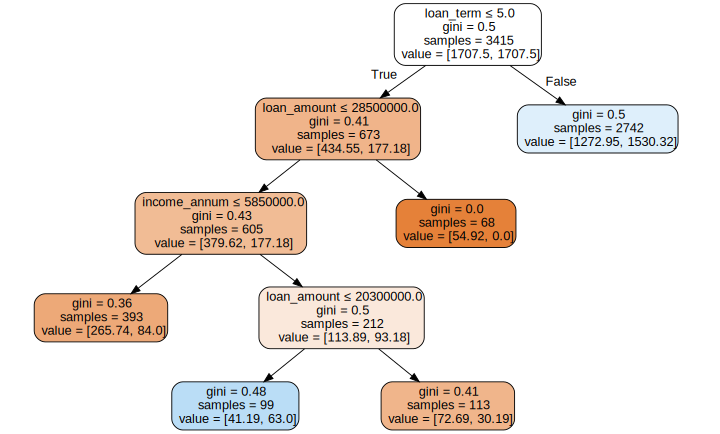

In [ ]:
draw_tree(tree, train_x, size=10)

Testing the models accuracy using the validation set

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

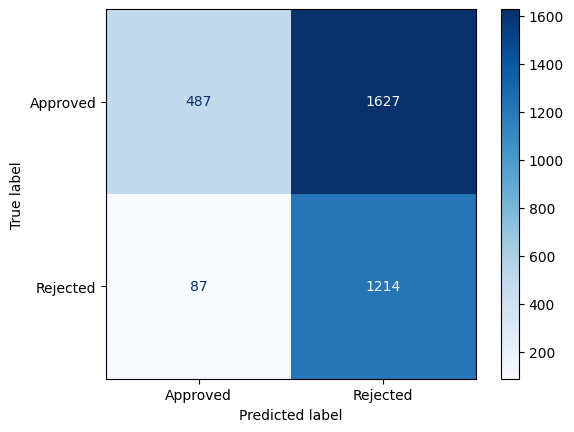

In [ ]:
train_pred = tree.predict(train_x)
cm = confusion_matrix(train_y, train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Approved', 'Rejected'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

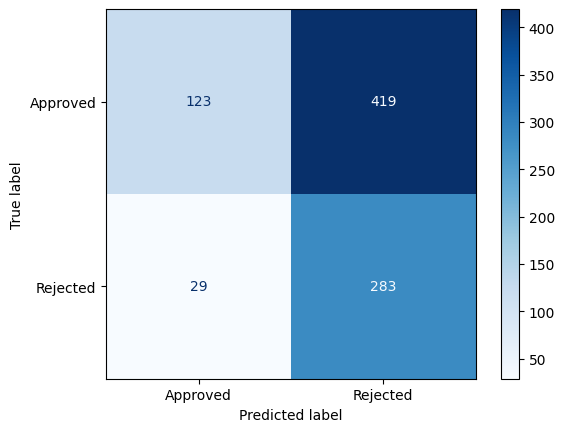

In [ ]:
val_pred = tree.predict(val_x)
cm = confusion_matrix(val_y, val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Approved', 'Rejected'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

The above matrices shows the precision of the model

[[TN, FP],  
 [FN, TP]]  

 Where:

TN = true negatives  
FP = false positives  
FN = false negatives  
TP = true positives  

Creating a random forest with many trees...

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(100, min_samples_leaf=20, class_weight='balanced', max_depth=10) # 100 trees in forest!
forest.fit(train_x, train_y);

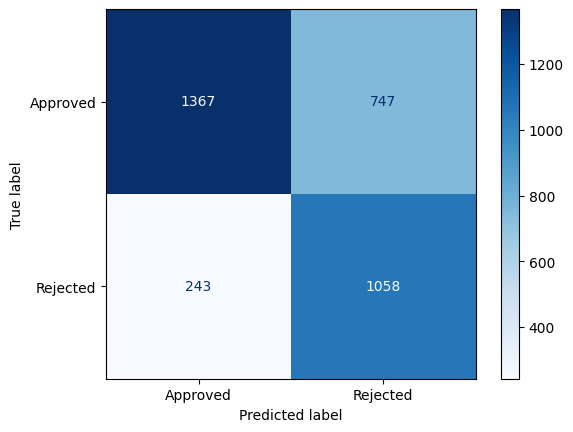

In [ ]:
forest_train_pred = forest.predict(train_x)
cm = confusion_matrix(train_y, forest_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Approved', 'Rejected'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

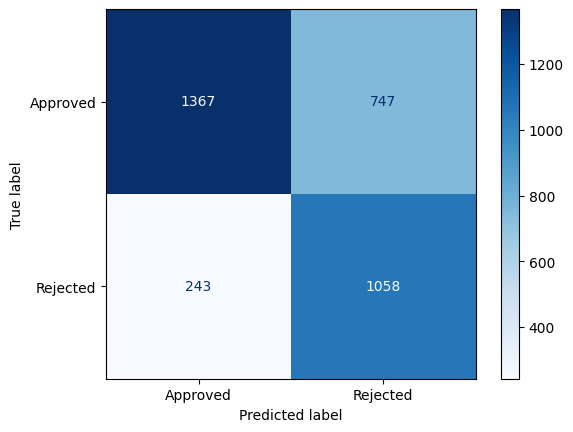

In [ ]:
forest_val_pred = forest.predict(val_x)
confusion_matrix(val_y, forest_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Approved', 'Rejected'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

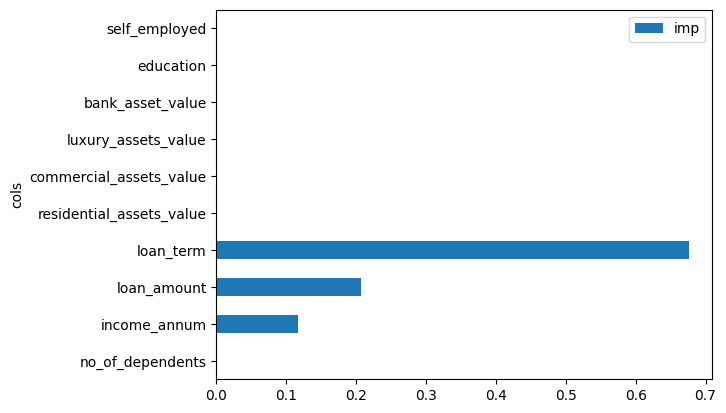

In [ ]:
pd.DataFrame(dict(cols=train_x.columns, imp=tree.feature_importances_)).plot('cols', 'imp', 'barh');